In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import json
import time
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Cargar datos y características
processed_data_path = '../../data/processed/final_processed_data.parquet'
features_path = '../../data/processed/final_features.json'

df = pd.read_parquet(processed_data_path)
with open(features_path, 'r') as f:
    final_features = json.load(f)

print("Datos y características cargados.")

Datos y características cargados.


In [3]:
# XGBoost Regressor con Pipeline
target_column = 'precio_mxn'
X = df[final_features]
y = df[target_column]

if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1, objective='reg:squarederror'))
])

print("\nEntrenando el modelo XGBoost...")
start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Entrenamiento completado en {training_time:.2f} segundos.")

y_pred_train = pipeline.predict(X_train)

start_time = time.time()
y_pred_test = pipeline.predict(X_test)
prediction_time = time.time() - start_time
print(f"Predicción completada en {prediction_time:.4f} segundos.")

def evaluate_model(y_true, y_pred, dataset_name=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nResultados {dataset_name}:")
    print(f"R²: {r2:.4f}")
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

train_metrics = evaluate_model(y_train, y_pred_train, "Entrenamiento")
test_metrics = evaluate_model(y_test, y_pred_test, "Prueba")

model_path = '../../models/xgboost_pipeline.joblib'
metrics_path = '../../models/xgboost_metrics.json'

joblib.dump(pipeline, model_path)
results = {
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'training_time': training_time,
    'prediction_time': prediction_time
}
with open(metrics_path, 'w') as f:
    json.dump(results, f)

print(f"\nModelo guardado en: {model_path}")
print(f"Métricas guardadas en: {metrics_path}")


Entrenando el modelo XGBoost...
Entrenamiento completado en 0.09 segundos.
Predicción completada en 0.0022 segundos.

Resultados Entrenamiento:
R²: 0.8934

Resultados Prueba:
R²: 0.7980

Modelo guardado en: ../../models/xgboost_pipeline.joblib
Métricas guardadas en: ../../models/xgboost_metrics.json


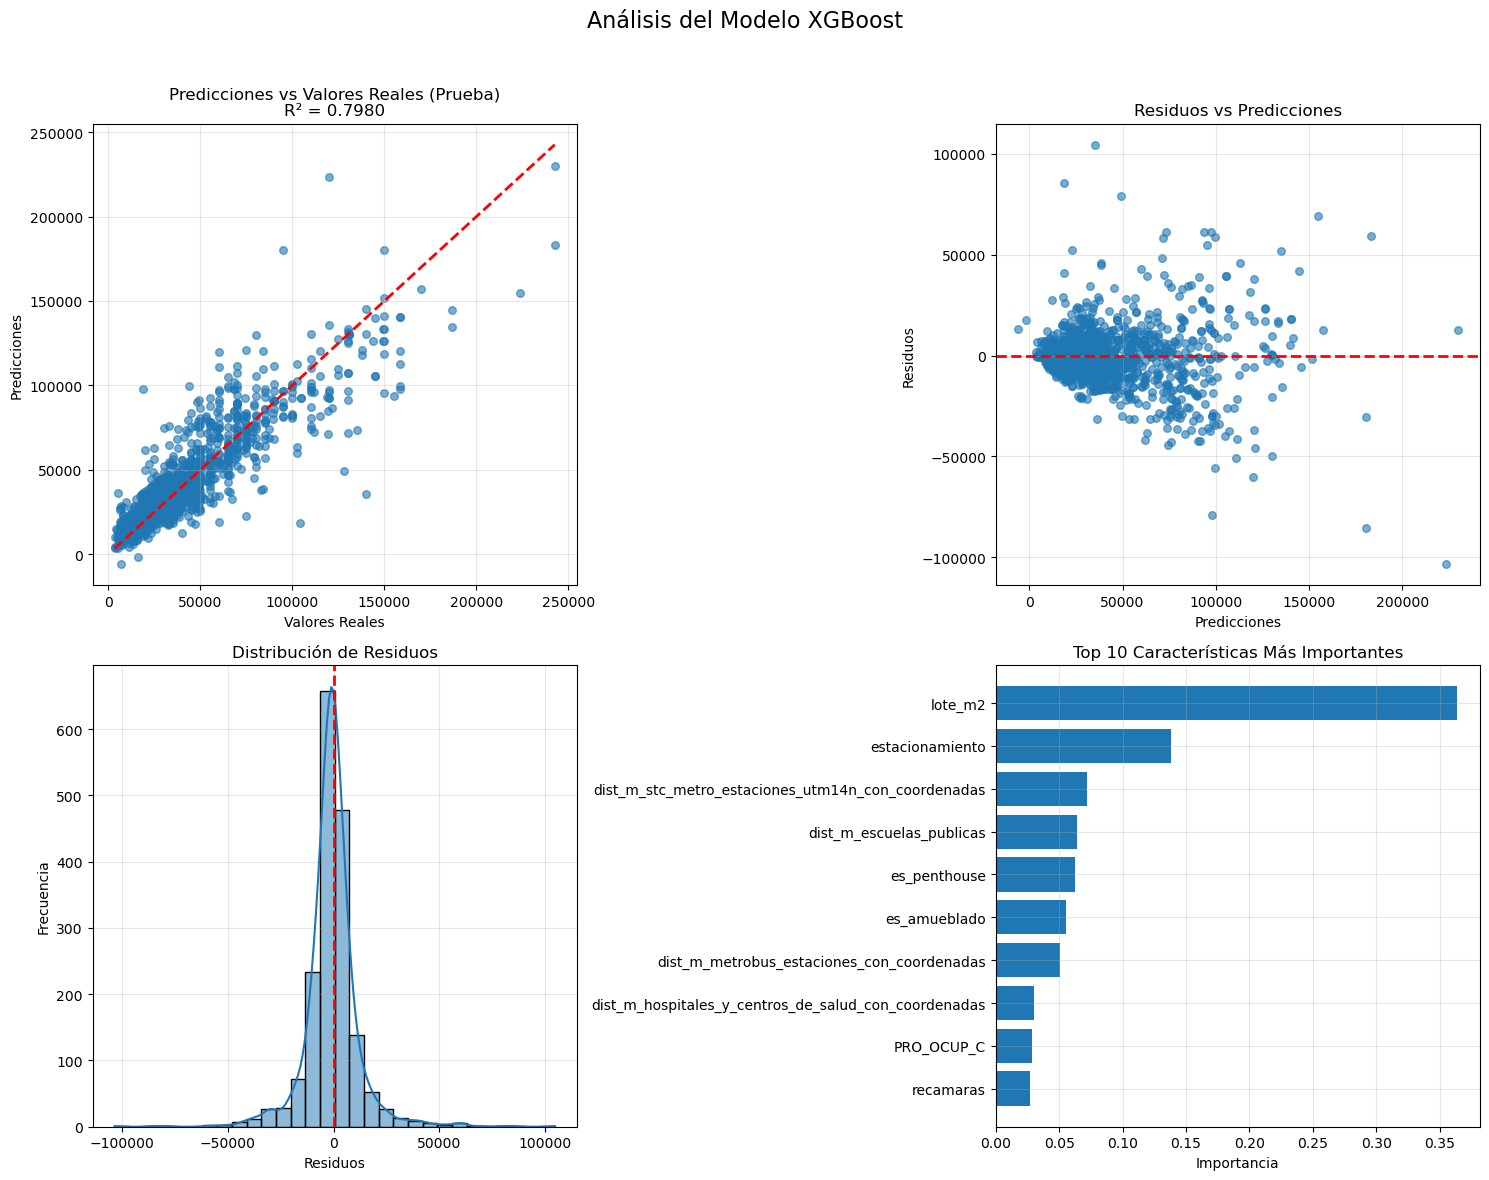

In [4]:
# Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'feature': final_features,
    'importance': pipeline.named_steps['regressor'].feature_importances_
}).sort_values('importance', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis del Modelo XGBoost', fontsize=16)

# 1. Predicciones vs Valores Reales
axes[0,0].scatter(y_test, y_pred_test, alpha=0.6, s=30)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
axes[0,0].set_title(f"Predicciones vs Valores Reales (Prueba)\nR² = {test_metrics['r2']:.4f}")
axes[0,0].set_xlabel("Valores Reales")
axes[0,0].set_ylabel("Predicciones")
axes[0,0].grid(True, alpha=0.3)

# 2. Residuos vs Predicciones
residuals_test = y_test - y_pred_test
axes[0,1].scatter(y_pred_test, residuals_test, alpha=0.6, s=30)
axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_title("Residuos vs Predicciones")
axes[0,1].set_xlabel("Predicciones")
axes[0,1].set_ylabel("Residuos")
axes[0,1].grid(True, alpha=0.3)

# 3. Distribución de residuos
sns.histplot(residuals_test, bins=30, kde=True, ax=axes[1,0])
axes[1,0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1,0].set_title("Distribución de Residuos")
axes[1,0].set_xlabel("Residuos")
axes[1,0].set_ylabel("Frecuencia")
axes[1,0].grid(True, alpha=0.3)

# 4. Importancia de características
top_10_features = feature_importance.head(10)
axes[1,1].barh(top_10_features['feature'], top_10_features['importance'])
axes[1,1].set_title("Top 10 Características Más Importantes")
axes[1,1].set_xlabel("Importancia")
axes[1,1].invert_yaxis()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()